# Fitting an Epigenetic Clock from Targeted Bisulfite Sequencing Methylation Matrix

In [1]:
# import stdlibs and third party libraries
import os
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import optimize
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from tqdm.notebook import tqdm

In [2]:
# use latex formatting for figures
rc('text', usetex=False)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Import Methylation Matrix
- read methylation matrix into *pandas* dataframe
- drop sites with missing data
- drop sites that show no variation (sites not useful for model fitting)

In [3]:
# read in methylation data
meth_matrix = pd.read_csv(f'TBS_methylation_matrix.tsv.gz', sep='\t', index_col=0)

In [4]:
# age data for model fitting 
sample_ages =  {'S10': 37,'S11': 42,'S12': 45,'S13': 53,'S14': 38, 'S15': 46,'S16': 49,
                'S17': 76, 'S18': 62, 'S19': 67, 'S1': 37, 'S20': 39,'S21': 45,'S22': 76,
                'S23': 32, 'S24': 52, 'S25': 30, 'S26': 63, 'S27': 47, 'S28': 45,'S29': 32,
                'S2': 64, 'S30': 33, 'S31': 52, 'S32': 54, 'S33': 57, 'S34': 47, 'S35': 34,
                'S36': 46, 'S37': 51, 'S38': 34, 'S39': 34, 'S3': 44, 'S40': 38, 'S41': 43, 
                'S42': 32, 'S43': 44,'S44': 51, 'S45': 41, 'S46': 44, 'S47': 51, 'S48': 59,
                'S4': 63, 'S5': 45, 'S6': 65, 'S7': 33, 'S8': 41, 'S9': 64}

In [5]:
# drop rows (CpG sites) with null data points 
meth_matrix = meth_matrix.dropna(axis=0)

In [6]:
# drop row that have little variation 
meth_matrix = meth_matrix.loc[meth_matrix.var(axis=1) >= 0.005]

In [7]:
# check size of final methylation matrix 
meth_matrix.shape

(16549, 48)

### PCA
- perform principal component analysis as a QC step
- check for sample outliers 

In [8]:
pca = PCA(whiten=False)

pcs = pca.fit_transform(meth_matrix.T.values)

variance_explained = pca.explained_variance_ratio_

- Close sample spread with little variation captured by 1st and 2nd PCs, keep all samples

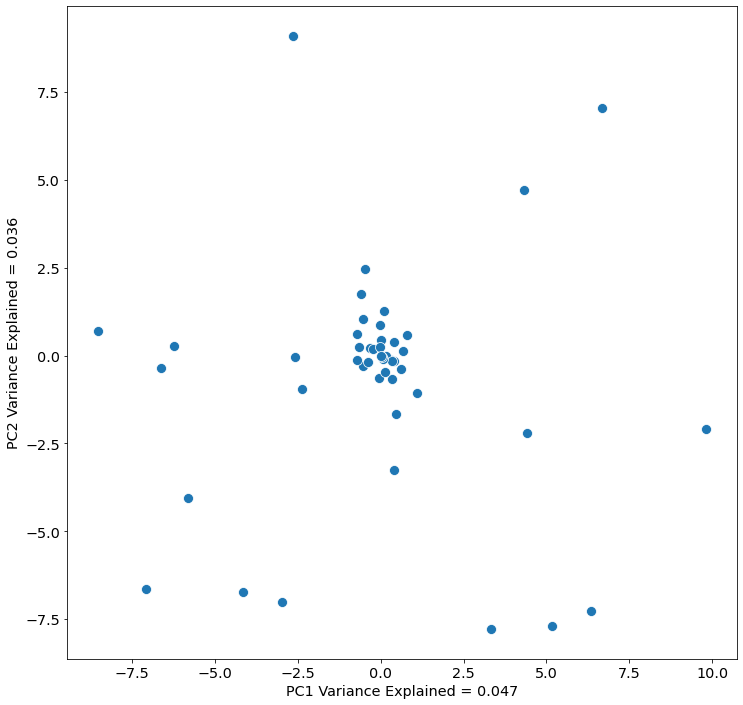

In [9]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(x=pcs[0], y=pcs[1], ax=ax, s=100)
ax.set_xlabel(f'PC1 Variance Explained = {variance_explained[0]:0.3f}')
ax.set_ylabel(f'PC2 Variance Explained = {variance_explained[1]:0.3f}')
#plt.savefig('pca.png', dpi=200, bbox_inches='tight')
plt.show()

### Fit epigenetic clock using penalized regression
- under for loop selected sample is held out as the testing sample
    - model is trained using all other samples
    - age prediction is made and saved for the held out sample

In [10]:
lm = ElasticNet(l1_ratio=.7, normalize=False, fit_intercept=True)

predicted_ages = {}

# tqdm for interactive progress bar 
for index in tqdm(range(len(sample_ages))):
    # leave on out cross validation 
    training_samples = [list(meth_matrix)[count] for count in range(len(sample_ages)) if count != index]
    
    # retrieve training values and ages for fold 
    training_ages = np.array([sample_ages[sample] for sample in training_samples])
    training_values = meth_matrix[training_samples].values
    
    # fit linear model
    lm.fit(training_values.T, training_ages)
    
    test_sample = list(meth_matrix)[index]
    
    # predict test age
    predicted_ages[test_sample] = [sample_ages[test_sample],  lm.predict(meth_matrix[[list(meth_matrix)[index]]].values.T)[0]]

### Model Evaluation 
- fit a trendline for the of known vs predicted ages
- evaluate the fit of the expected vs predicted ages based on the trendline using Pearson correlation ($R^{2}$)
- Plot data and trendline w/ equation

In [11]:
rc('text', usetex=False)

def r2(x,y):
    # return r squared
    return stats.pearsonr(x,y)[0] ** 2

def plot_known_predicted_ages(known_ages, predicted_ages, label=None):
    # define optimization function
    def func(x, a, b, c):
        return a * np.asarray(x) + c
    # fit trend line
    popt, pcov = optimize.curve_fit(func, known_ages, predicted_ages)
    # get r squared
    rsquared = r2(predicted_ages, func(known_ages, *popt))
    # format plot label
    plot_label = f'$f(x)={popt[0]:.2f}x {popt[2]:.2f}, R^{{2}}={rsquared:.2f}$'
    # initialize plt plot
    fig, ax = plt.subplots(figsize=(12,12))
    # plot trend line
    ax.plot(sorted(known_ages), func(sorted([1 + x for x in known_ages]), *popt), 'r--', label=plot_label)
    # scatter plot
    ax.scatter(known_ages, predicted_ages, marker='o', alpha=0.8, color='k')
    ax.set_title(label, fontsize=18)
    ax.set_xlabel('Chronological Age', fontsize=16)
    ax.set_ylabel('Epigenetic State', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    plt.show()

/u/home/c/colinpat/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


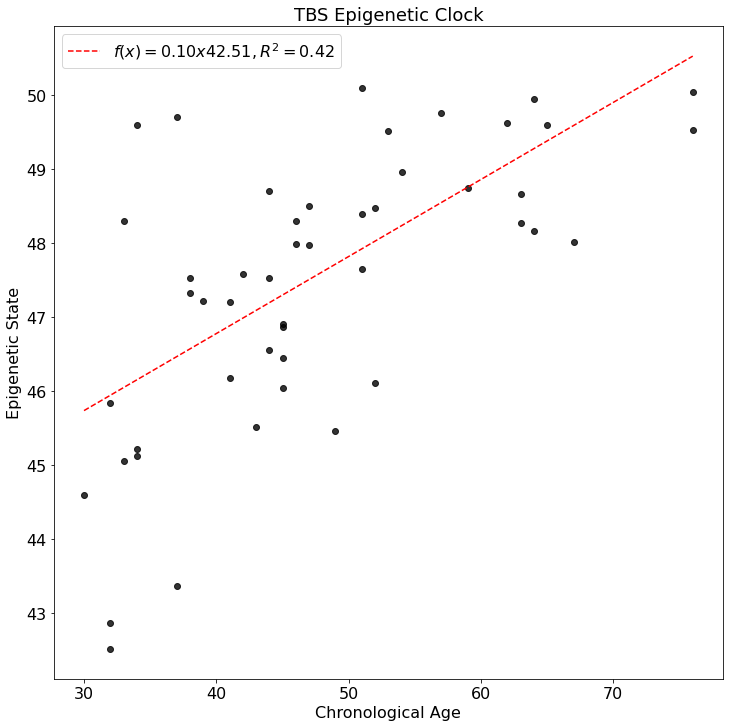

In [12]:
plot_known_predicted_ages([age[0] for age in predicted_ages.values()], [age[1] for age in predicted_ages.values()], 'TBS Epigenetic Clock')